In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, recall_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from pprint import pprint
from scipy import stats
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv("/content/drive/MyDrive/laterite_mobilemoney_data.csv")

In [3]:
df.head()

,start_time,end_time,hhid,account_num,account_type,weight,district,urban,gender,age,hh_members,highest_grade_completed,mm_account_cancelled,prefer_cash,mm_trust,mm_account_telco,mm_account_telco_main,v234,agent_trust,v236,v237,v238,v240,v241,v242,v243,v244,v245,v246
0,"Oct 28, 2019 9:05:08 AM","Oct 28, 2019 10:38:45 AM",1001,1,Mobile Money,145.94444,District_A,Urban,male,32,1,primary 6,no,yes,no,Company_A Company_B,Company_A,yes,no,NaN,yes,yes,no,yes,no,yes,NaN,yes,no
1,"Oct 28, 2019 10:42:17 AM","Oct 28, 2019 11:43:25 AM",1001,2,Bank Account,145.94444,District_A,Urban,male,32,1,primary 6,no,yes,no,Company_A Company_B,Company_A,yes,no,NaN,yes,yes,no,yes,no,yes,NaN,yes,no
2,"Oct 28, 2019 11:47:47 AM","Oct 28, 2019 12:53:31 PM",1001,3,VSLA Account,145.94444,District_A,Urban,male,32,1,primary 6,no,yes,no,Company_A Company_B,Company_A,yes,no,NaN,yes,yes,no,yes,no,yes,NaN,yes,no
3,"Oct 28, 2019 1:02:33 PM","Oct 28, 2019 1:56:43 PM",1002,1,SACCO Account,122.90667,District_B,Rural,male,32,4,primary 3,yes,yes,no,NaN,NaN,NaN,no,NaN,yes,yes,yes,no,no,no,NaN,no,no
4,"Oct 28, 2019 2:01:04 PM","Oct 28, 2019 2:58:34 PM",1002,2,VSLA Account,122.90667,District_B,Rural,male,32,4,primary 3,yes,yes,no,NaN,NaN,NaN,no,NaN,yes,yes,yes,no,no,no,NaN,no,no


For **Question 1**, we may want to see display how many products a single ID has. For doing so, we use the function below.

In [13]:
df1 = df.groupby("hhid")["account_type"].value_counts()

hhid  account_type 
1001  Bank Account     1
      Mobile Money     1
      VSLA Account     1
1002  SACCO Account    1
      VSLA Account     1
                      ..
2204  VSLA Account     1
2205  Bank Account     1
      Mobile Money     1
      SACCO Account    1
      VSLA Account     1
Name: account_type, Length: 2442, dtype: int64

For **Question 2**, I created two dummy variables for each ID: ***Financially excluded*** and ***Digital inclusion***. Both can be seen as boolean expresions but for predicting purposes I rather prefer to transform them into integers so we can later on do some ML predictions

In [10]:
#df['Dropout'] = ((df.Grade_2012 != "Not in class") & (df.Grade_2013 == "Not in class")).map({True: 1, False: 0})
df["financially_excluded"] = (df.account_type !="None") & (df.account_type == "Mobile Money") & (df.account_type =="VSLA Account") & (df.account_type == "SACCO Account") & (df.account_type == "Bank Account") & (df.account_type =="Online Bank Account")

In [11]:
df["financially_excluded"] = df["financially_excluded"].map({True:1, False:0})

In [12]:
#Digital financial inclusion 
df["digital_inclusion"] = (df.account_type == "Mobile Money") | (df.account_type == "Online Bank Account") & (df.account_type != "None") & (df.account_type != "VSLA Account") & (df.account_type != "SACCO Account") & (df.account_type != "Bank Account")

In [13]:
df["digital_inclusion"] = df["digital_inclusion"].map({True:1, False:0})

I also consider that from now on, its important to do some EDA so we can have an intuition of which variables may be correlated to the dependant variable, **which is how likely clients will cancel their mobile money account (mm_account_cancelled)**.

So as we can see, Mobile Money shares is 33%, so it is the most popular among the remaining. Slightly, VSLA Account also counts for 28% of the share. So from this perspective, not that the Mobile Money will remain the majority of preference among clients. So first off, worth it to explore which target prefer VSLA Account, how they ended up adquiring this product. So far, VSLA Account is the traditional product among the sample of this study, which is majority rural. From Question 1 descriptive, we have seen that clients can have both products. From a microfinance perspective, it is ok to increase the number of products among customers, but mobile money operators only require a mobile and internet to operate, so worth it the make it the preferred one among the clients. 

In [15]:
df.account_type.value_counts(normalize = True)

Mobile Money           0.338657
VSLA Account           0.278460
SACCO Account          0.191646
Bank Account           0.132269
None                   0.054054
Online Bank Account    0.004914
Name: account_type, dtype: float64

**Question 3. **

As we can see in the descriptive below, Commpany_A and Company_B are the ones that customers prefer to have a mobile money account. So we can do the following actions: stick to Company A and B for promotions and that way increase share, or seeing Company C as a potential brand that need to fuel some promotions and advertising so they can increase market share. 

In [16]:
#Cross tab by company vs mobile money account
df.mm_account_telco.value_counts(normalize= True)

Company_A Company_B              0.426680
Company_A                        0.270876
Company_B                        0.204175
Company_A Company_B Company_C    0.034114
Company_A Company_C              0.028004
Company_B Company_C              0.022912
Company_C                        0.013238
Name: mm_account_telco, dtype: float64

Likewise, Company A and B are more prone to have clients that are digital oriented in terms of banking.

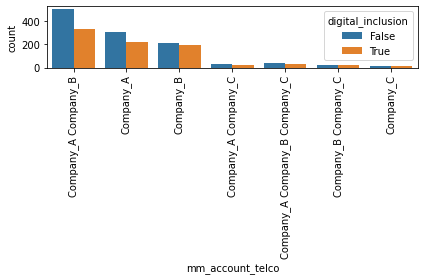

In [10]:
sns.countplot(x="mm_account_telco", hue="digital_inclusion", data=df)
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()

Among all the dataset, Its company A and B indeed, the ones that are preferred among the clients that are digital included. 

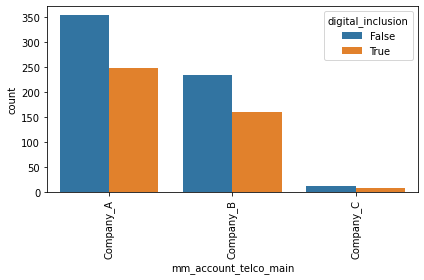

In [11]:
sns.countplot(x="mm_account_telco_main", hue="digital_inclusion", data=df)
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()

I also explored, if there is relationship between cancelling a mobile account and the providers for the mobile money account. In the graph below, in the legend, 0 stands for not cancelled and 1 for cancelled. As we can see, none of the companies are related to cancelled in the past. Actually the company that is doing a good performance in this regard is Company A. 

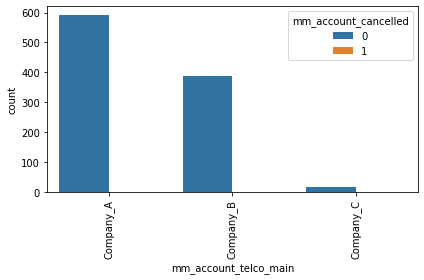

In [23]:
sns.countplot(x="mm_account_telco_main", hue="mm_account_cancelled", data=df)
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()

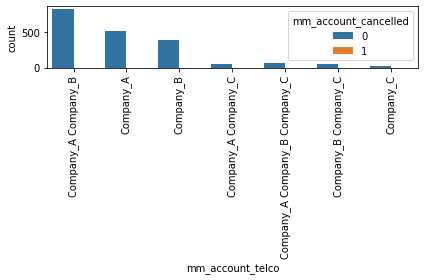

In [24]:
sns.countplot(x="mm_account_telco", hue="mm_account_cancelled", data=df)
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()

In [12]:
df.mm_account_telco_main.value_counts()

Company_A    600
Company_B    393
Company_C     18
Name: mm_account_telco_main, dtype: int64

In [ ]:
#df.groupby('hhid')['account_type'].value_counts().unstack().fillna(0)

We just continue exploring if we have some missing values that worth it to transform so we can work with them later on for prediction

In [14]:
df.isnull().sum()

start_time                    0
end_time                      0
hhid                          0
account_num                   0
account_type                  0
weight                        0
district                      0
urban                         0
gender                        0
age                           0
hh_members                    0
highest_grade_completed     207
mm_account_cancelled          0
prefer_cash                  47
mm_trust                    128
mm_account_telco            478
mm_account_telco_main      1431
v234                        594
agent_trust                 808
v236                       1799
v237                        296
v238                        287
v240                        287
v241                        336
v242                        341
v243                        296
v244                       1867
v245                        296
v246                        287
financially_excluded          0
digital_inclusion             0
dtype: i

The variable v240 which ask if a transaction ever failed to go through, its important explore and so forth, to clean it up because this feature may cause that clients decide it to keep digital products or to drop them. So that's why I decided to clean it up. 

In [17]:
df = df[df['v240'].notna()]

Luckily, as we have seen below the transactions are not likely to fail (only 28% of the cases are named as failed)

In [19]:
df.v240.value_counts(normalize=True)

no     0.727146
yes    0.272854
Name: v240, dtype: float64

In [16]:
#4, question v240
df.urban.value_counts()

Rural    1613
Urban     542
Name: urban, dtype: int64

In [45]:
df["urban"] = df["urban"].map({"Urban":0, "Rural":1})

In [ ]:
df.dtypes

In [20]:
df["v240"] = df["v240"].map({"no":0, "yes":1})

***Question 4 ***asks for finding statistical differences in the share of customers who have experienced failed mobile money transactions in rural and urban villages. For that we need first to load packages and later, doing some data transformation for establishing the different groups to compare. 

In [12]:
from scipy.stats import ttest_ind #to run the t-test for independent samples
from scipy import stats
from scipy.stats import spearmanr #to run spearman

In [14]:
#df['Sex'] = df['Sex'].map({"Female": 0, "Male": 1})
df['urban'] = df['urban'].map({"Rural": 0, "Urban": 1})
#df['Sex'] = df['Sex'].apply({'Male':1, 'Female': 0}.get)

In [21]:
df.v240.isnull

<bound method Series.isnull of 0       0
1       0
2       0
3       1
4       1
       ..
2435    0
2438    1
2439    1
2440    1
2441    1
Name: v240, Length: 2155, dtype: int64>

In [22]:
Rural = df[df['urban']==0]
Urban = df[df['urban']==1]

For responding this question I used the independent sample t-test among rural vs urban population. So that is why I split the dataset and the ouput below shows that there is not significant differences regarding rural vs urban populations. This means that the kind of geography is not related with a crash in the transations that a client may display. So we may assume that that the companies that operate in those areas are not having difficulties in this regard. 

In [16]:
#let's see if rural are more or less likely to v240 than urban
ttest_ind(Rural['v240'], Urban['v240'], nan_policy='omit')

Ttest_indResult(statistic=-6.653240450605926, pvalue=3.6249095821554155e-11)

**Question 5** asks for the variables that are good predictors that someone will cancel their mobile money account? Discuss what causes a customer to stop using their mobile money account including how strong the evidence is.

In order to respond this question, still worth it to do some EDA so we can select the potential independent variables that may explain whether a person is likely to cancel a mobile money account or not. I start off with using ***mm_account_cancelled ***as a dependent variable. As we can see 90% of people hasnt cancelled their mobile account. This is a good indicator but for predicting it may causes a problem because we notice that the Dependent variable is imbalance, so it worth to balance with different approaches. One of the most common ones is SMOTE, but given the limitation of time I'm not doing imbalancing for this experiment 

In [27]:


df.mm_account_cancelled.value_counts( normalize = True)

0    0.902552
1    0.097448
Name: mm_account_cancelled, dtype: float64

In [28]:
df['mm_account_cancelled'] = df['mm_account_cancelled'].map({"no": 0, "yes": 1})

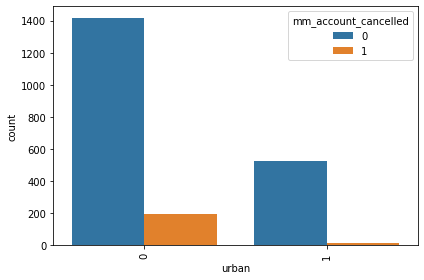

In [20]:
#Lets do some EDA so we can suspect about some variables that may tell us whether a client is likely
#to cancel or not their mobibe money account

sns.countplot(x="urban", hue="mm_account_cancelled", data=df)
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()

#With 0 being rural, among them, there are few chances of cancel your mobile account(since 0 is no cancelled)
#With 1 being urban, among them, there are few chances of cancel your mobile account. 
#Still, seems that cancel is more likely to happen in rural areas. But this may looks this way because
#of the imbalanced data.
#Overall, seems that region variable does not have an impact whether or not someone cancel 


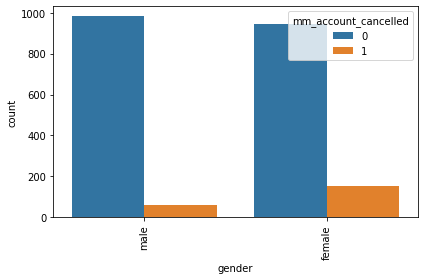

In [26]:
sns.countplot(x="gender", hue="mm_account_cancelled", data=df)
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()

#With gender, it seems that women are more likely to cancel than men. So SEx may be
#a good predictor for canceling or not. 

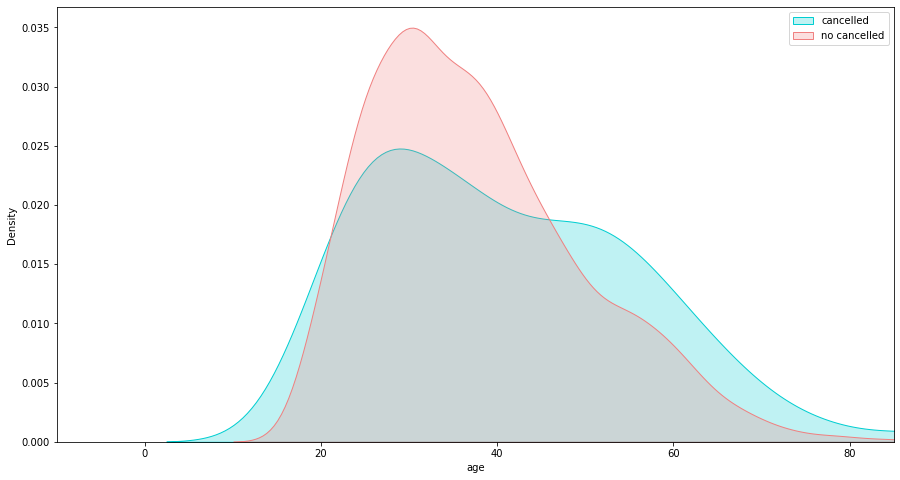

In [23]:
#df.age.value_counts()
plt.figure(figsize=(15,8))
ax = sns.kdeplot(df["age"][df.mm_account_cancelled == 1], color="darkturquoise", shade=True)
sns.kdeplot(df["age"][df.mm_account_cancelled == 0], color="lightcoral", shade=True)
plt.legend(['cancelled', 'no cancelled'])
#plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='age')
plt.xlim(-10,85)
plt.show()



In [28]:
df.dtypes

start_time                  object
end_time                    object
hhid                         int64
account_num                  int64
account_type                object
weight                     float64
district                    object
urban                        int64
gender                      object
age                          int64
hh_members                   int64
highest_grade_completed     object
mm_account_cancelled         int64
prefer_cash                 object
mm_trust                    object
mm_account_telco            object
mm_account_telco_main       object
v234                        object
agent_trust                 object
v236                        object
v237                        object
v238                        object
v240                         int64
v241                        object
v242                        object
v243                        object
v244                        object
v245                        object
v246                

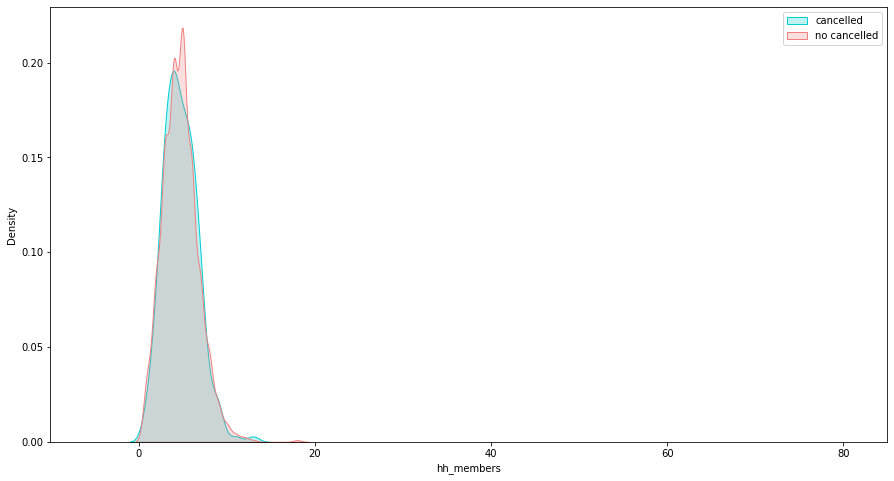

In [27]:
#df.age.value_counts()
plt.figure(figsize=(15,8))
ax = sns.kdeplot(df["hh_members"][df.mm_account_cancelled == 1], color="darkturquoise", shade=True)
sns.kdeplot(df["hh_members"][df.mm_account_cancelled == 0], color="lightcoral", shade=True)
plt.legend(['cancelled', 'no cancelled'])
#plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='hh_members')
plt.xlim(-10,85)
plt.show()

#seems that the more the members of the family, more likely not to cancel the mobile money account

In [12]:
df.highest_grade_completed.value_counts()

primary 6      579
secondary 6    228
university     198
primary 5      174
primary 4      173
primary 3      142
secondary 3    135
primary 2       83
secondary 2     63
tvet            62
secondary 4     53
secondary 5     47
primary 1       40
secondary 1     31
other           11
Name: highest_grade_completed, dtype: int64

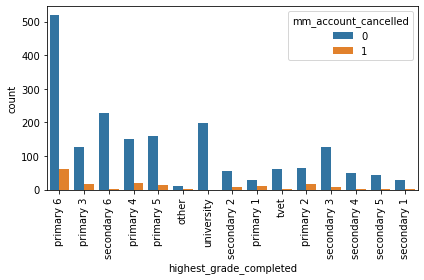

In [15]:
sns.countplot(x="highest_grade_completed", hue="mm_account_cancelled", data=df)
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()


In [38]:
df1 = df.highest_grade_completed.groupby([df.highest_grade_completed, df.mm_account_cancelled]).size().unstack().fillna(0).astype(str)

df1.index.name = None
df1.columns.name = None
print(df1)

#Among the people that cancelled, the ones that reached primary 6 as the highest grade are more likely to cancel
#compared to the other grades. 

                 0     1
other         10.0   1.0
primary 1     29.0  11.0
primary 2     65.0  18.0
primary 3    126.0  16.0
primary 4    152.0  21.0
primary 5    160.0  14.0
primary 6    519.0  60.0
secondary 1   29.0   2.0
secondary 2   54.0   9.0
secondary 3  128.0   7.0
secondary 4   50.0   3.0
secondary 5   45.0   2.0
secondary 6  227.0   1.0
tvet          61.0   1.0
university   198.0   0.0


In [27]:
df.prefer_cash.value_counts()

yes    2033
no       89
Name: prefer_cash, dtype: int64

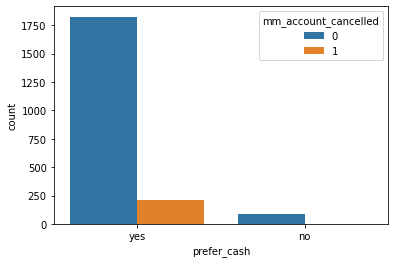

In [47]:
sns.countplot(x="prefer_cash", hue="mm_account_cancelled", data=df);

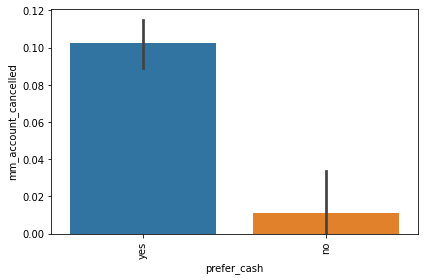

In [48]:
sns.barplot(x="prefer_cash", y="mm_account_cancelled", data=df)
# use the original locations of your xticks, and only the date for your label
# rotate the labels 90 degrees using the rotation argument
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()

#the ones that prefer cash are more likely to cancel 

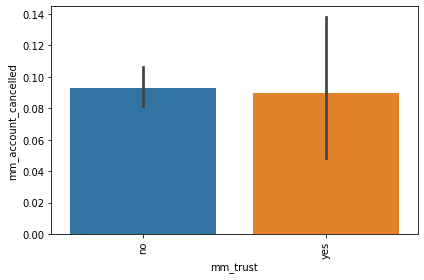

In [49]:
sns.barplot(x="mm_trust", y="mm_account_cancelled", data=df)
# use the original locations of your xticks, and only the date for your label
# rotate the labels 90 degrees using the rotation argument
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()
#Surprisingly the ones that trust mobile money are slightly likely to cancel. 

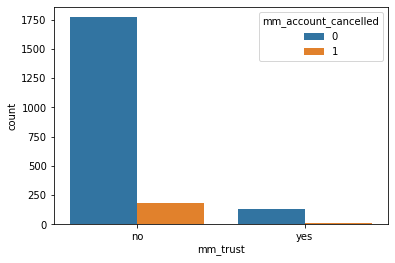

In [50]:
sns.countplot(x="mm_trust", hue="mm_account_cancelled", data=df);

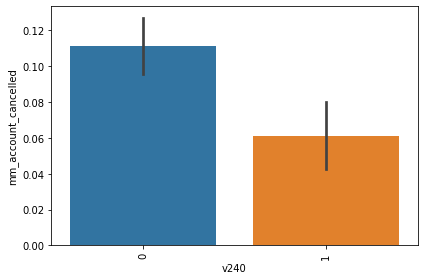

In [51]:
sns.barplot(x="v240", y="mm_account_cancelled", data=df)
# use the original locations of your xticks, and only the date for your label
# rotate the labels 90 degrees using the rotation argument
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()

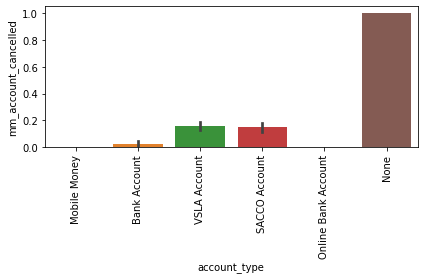

In [31]:
sns.barplot(x="account_type", y="mm_account_cancelled", data=df)
# use the original locations of your xticks, and only the date for your label
# rotate the labels 90 degrees using the rotation argument
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()

#The graph shows us that both VSLA Account and SACCO Account owners are more likely to cancel their
#mobile account. They may be more comfortable with this kind of accounts. 
#may be worth it to address on a qualitative level what are the attributes that they like 
#from both accounts to stick with them. 

In [29]:
df.v234.value_counts()

yes    1396
no      410
-97      17
Name: v234, dtype: int64

In [30]:
df.drop(df[df['v234'] == '-97' ].index, inplace=True)

# Delete these row indexes from dataFrame
#df.drop(indexNames , inplace=True)
print(df)

                    start_time  ... digital_inclusion
0      Oct 28, 2019 9:05:08 AM  ...                 1
1     Oct 28, 2019 10:42:17 AM  ...                 0
2     Oct 28, 2019 11:47:47 AM  ...                 0
3      Oct 28, 2019 1:02:33 PM  ...                 0
4      Oct 28, 2019 2:01:04 PM  ...                 0
...                        ...  ...               ...
2435   Oct 31, 2019 9:17:34 AM  ...                 0
2438    Nov 5, 2019 2:59:48 PM  ...                 1
2439    Nov 5, 2019 3:54:18 PM  ...                 0
2440    Nov 5, 2019 5:25:47 PM  ...                 0
2441   Nov 6, 2019 11:05:26 AM  ...                 0

[2138 rows x 31 columns]


In [31]:
df['v234'] = df['v234'].map({"no": 0, "yes": 1})

In [23]:
df.agent_trust.value_counts()

no     1324
yes     283
-97       1
Name: agent_trust, dtype: int64

In [32]:
df.drop(df[df['agent_trust'] == '-97' ].index, inplace=True)

# Delete these row indexes from dataFrame
#df.drop(indexNames , inplace=True)
print(df)

                    start_time  ... digital_inclusion
0      Oct 28, 2019 9:05:08 AM  ...                 1
1     Oct 28, 2019 10:42:17 AM  ...                 0
2     Oct 28, 2019 11:47:47 AM  ...                 0
3      Oct 28, 2019 1:02:33 PM  ...                 0
4      Oct 28, 2019 2:01:04 PM  ...                 0
...                        ...  ...               ...
2435   Oct 31, 2019 9:17:34 AM  ...                 0
2438    Nov 5, 2019 2:59:48 PM  ...                 1
2439    Nov 5, 2019 3:54:18 PM  ...                 0
2440    Nov 5, 2019 5:25:47 PM  ...                 0
2441   Nov 6, 2019 11:05:26 AM  ...                 0

[2137 rows x 31 columns]


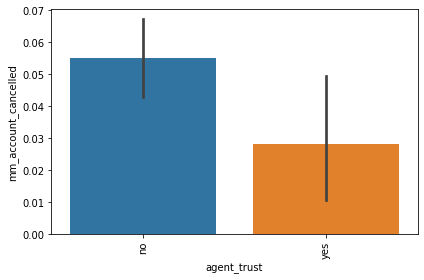

In [21]:
sns.barplot(x="agent_trust", y="mm_account_cancelled", data=df)
# use the original locations of your xticks, and only the date for your label
# rotate the labels 90 degrees using the rotation argument
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
sns.barplot(x="agent_trust", y="mm_account_cancelled", data=df)
# use the original locations of your xticks, and only the date for your label
# rotate the labels 90 degrees using the rotation argument
plt.xticks(plt.xticks()[0], rotation=90)
plt.tight_layout()
plt.show()

In [33]:
df.v236.isnull

<bound method Series.isnull of 0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
2435    NaN
2438     no
2439     no
2440     no
2441     no
Name: v236, Length: 2137, dtype: object>

In [34]:
df.drop(df[df['v236'] == 'NaN' ].index, inplace=True)

# Delete these row indexes from dataFrame
#df.drop(indexNames , inplace=True)
print(df)

                    start_time  ... digital_inclusion
0      Oct 28, 2019 9:05:08 AM  ...                 1
1     Oct 28, 2019 10:42:17 AM  ...                 0
2     Oct 28, 2019 11:47:47 AM  ...                 0
3      Oct 28, 2019 1:02:33 PM  ...                 0
4      Oct 28, 2019 2:01:04 PM  ...                 0
...                        ...  ...               ...
2435   Oct 31, 2019 9:17:34 AM  ...                 0
2438    Nov 5, 2019 2:59:48 PM  ...                 1
2439    Nov 5, 2019 3:54:18 PM  ...                 0
2440    Nov 5, 2019 5:25:47 PM  ...                 0
2441   Nov 6, 2019 11:05:26 AM  ...                 0

[2137 rows x 31 columns]


In [35]:
df.isnull().sum()

start_time                    0
end_time                      0
hhid                          0
account_num                   0
account_type                  0
weight                        0
district                      0
urban                         0
gender                        0
age                           0
hh_members                    0
highest_grade_completed     136
mm_account_cancelled       2137
prefer_cash                  33
mm_trust                     55
mm_account_telco            219
mm_account_telco_main      1148
v234                        332
agent_trust                 530
v236                       1508
v237                          9
v238                          0
v240                          0
v241                         49
v242                         54
v243                          9
v244                       1564
v245                          9
v246                          0
financially_excluded          0
digital_inclusion             0
dtype: i

Standarization process 


In [37]:
df.dtypes

start_time                  object
end_time                    object
hhid                         int64
account_num                  int64
account_type                object
weight                     float64
district                    object
urban                       object
gender                      object
age                          int64
hh_members                   int64
highest_grade_completed     object
mm_account_cancelled       float64
prefer_cash                 object
mm_trust                    object
mm_account_telco            object
mm_account_telco_main       object
v234                       float64
agent_trust                 object
v236                        object
v237                        object
v238                        object
v240                         int64
v241                        object
v242                        object
v243                        object
v244                        object
v245                        object
v246                

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

In [38]:
#dropping columns that not add any info

#train_data_dummies=pd.get_dummies(df, columns=[])


In [ ]:
df["account_type"] = df["account_type"].astype(int)

In [47]:
train_data_dummies=pd.get_dummies(df, columns=["urban","age","hh_members", 
                                               "highest_grade_completed", "prefer_cash", 
                                               "mm_trust", "mm_account_telco", 
                                               "mm_account_telco_main", "financially_excluded", 
                                               "digital_inclusion", "mm_account_cancelled"])

train_data_dummies = df.copy()
train_data_dummies.drop("account_type", axis = 1, inplace = True)
train_data_dummies.drop("gender", axis = 1, inplace = True)
train_data_dummies.drop('start_time', axis=1, inplace=True)
train_data_dummies.drop('end_time', axis=1, inplace=True)
train_data_dummies.drop('hhid', axis=1, inplace=True)
train_data_dummies.drop('account_num', axis=1, inplace=True)
train_data_dummies.drop('weight', axis=1, inplace=True)
train_data_dummies.drop('district', axis=1, inplace=True)
#train_data.drop("edu_expenes", axis = 1, inplace = True)
train_data_dummies.drop('v234', axis=1, inplace=True)
train_data_dummies.drop('agent_trust', axis=1, inplace=True)
#train_data.drop("Sex", axis = 1, inplace=True)
train_data_dummies.drop('v236', axis=1, inplace=True)
train_data_dummies.drop('v237', axis=1, inplace=True)
train_data_dummies.drop('v238', axis=1, inplace=True)
train_data_dummies.drop('v241', axis=1, inplace=True)
train_data_dummies.drop('v242', axis=1, inplace=True)
train_data_dummies.drop('v243', axis=1, inplace=True)
train_data_dummies.drop('v244', axis=1, inplace=True)
train_data_dummies.drop('v245', axis=1, inplace=True)
train_data_dummies.drop('v246', axis=1, inplace=True)



final_train = train_data_dummies

# standardization for just numerical variables 
categorical_cols= ["urban","highest_grade_completed", "prefer_cash", 
                                               "mm_trust", "mm_account_telco", 
                                               "mm_account_telco_main"]

feature_scale=[feature for feature in final_train.columns if feature not in categorical_cols]

scaler=StandardScaler()
scaler.fit(final_train[feature_scale])
X=final_train[categorical_cols]
y=final_train["mm_account_cancelled"]

# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model, 8)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ValueError: ignored